# Initialization

In [9]:
import nltk
print(nltk.__version__)

3.9.1


In [10]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\CTN new
[nltk_data]     Installation\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\CTN new
[nltk_data]     Installation\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\CTN new
[nltk_data]     Installation\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Part 2: Preprocessing

In [11]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### 2.1 Data Cleaning

In [12]:
# Load data
df = pd.read_csv('combined_news_articles_data.csv')

# Handle missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Fill missing dates with mode
df['published_date'] = df['published_date'].fillna('Unknown date')

# Drop rows with missing content
df = df.dropna(subset=['article_content'])

# Remove duplicates
df = df.drop_duplicates(subset=['headline'])

# Convert dates to datetime format (if needed)
try:
    df['published_date'] = pd.to_datetime(df['published_date'])
except:
    pass

print("\nData after cleaning:")
print(f"Total articles: {len(df)}")
print(df.info())

Missing values before cleaning:
published_date       0
headline             0
publisher            0
article_content    117
category             0
dtype: int64

Data after cleaning:
Total articles: 1053
<class 'pandas.core.frame.DataFrame'>
Index: 1053 entries, 0 to 1312
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   published_date   1053 non-null   datetime64[ns]
 1   headline         1053 non-null   object        
 2   publisher        1053 non-null   object        
 3   article_content  1053 non-null   object        
 4   category         1053 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 49.4+ KB
None


### 2.2 Text Preprocessing

In [13]:
# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Initialize objects
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and lemmatize
    processed = [lemmatizer.lemmatize(word) for word in tokens 
                if word not in stop_words and len(word) > 2]
    
    return ' '.join(processed)

# Apply preprocessing
df['clean_content'] = df['article_content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to C:\Users\CTN new
[nltk_data]     Installation\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\CTN new
[nltk_data]     Installation\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\CTN new
[nltk_data]     Installation\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\CTN new
[nltk_data]     Installation\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [14]:
# Show example
print("\nOriginal vs Cleaned Text:")
print("Original:", df['article_content'].iloc[1][:200])
print("Cleaned:", df['clean_content'].iloc[1][:200])


Original vs Cleaned Text:
Original: House Republicans have passed a sweeping multi-trillion dollar tax breaks package, a narrow victory for President Donald Trump and House Speaker Mike Johnson after weeks of negotiations with conservat
Cleaned: house republican passed sweeping multitrillion dollar tax break package narrow victory president donald trump house speaker mike johnson week negotiation conservative holdoutstrumps big beautiful bill


### 2.3 Handle Class Imbalance

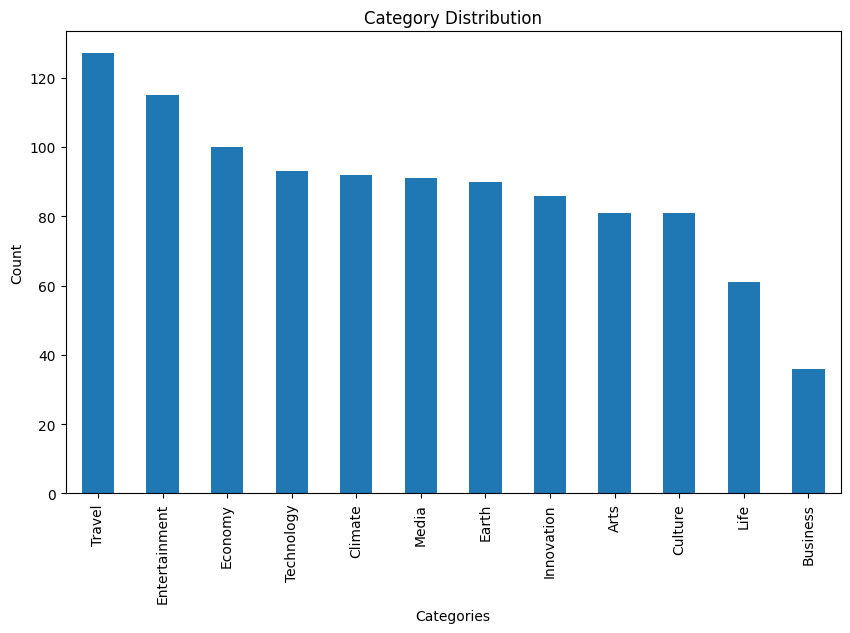


Resampled class distribution: (array(['Arts', 'Business', 'Climate', 'Culture', 'Earth', 'Economy',
       'Entertainment', 'Innovation', 'Life', 'Media', 'Technology',
       'Travel'], dtype=object), array([127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127]))


In [15]:
# Check class distribution
category_dist = df['category'].value_counts()
plt.figure(figsize=(10,6))
category_dist.plot(kind='bar')
plt.title('Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

# Handle imbalance using SMOTE (example)
if len(category_dist) > 1:
    from imblearn.over_sampling import SMOTE
    from sklearn.feature_extraction.text import TfidfVectorizer

    # Vectorize text
    tfidf = TfidfVectorizer(max_features=5000)
    X = tfidf.fit_transform(df['clean_content'])
    y = df['category']

    # Resample
    smote = SMOTE()
    X_res, y_res = smote.fit_resample(X, y)
    
    print("\nResampled class distribution:", np.unique(y_res, return_counts=True))
else:
    print("Insufficient classes for balancing")

### 2.4 Exploratory Data Analysis (EDA)


Basic Statistics:
Average word count: 436.6486229819563
Most common words: said       4822
year       2801
say        2416
also       2192
company    1990
new        1812
one        1685
people     1498
like       1474
time       1373
Name: count, dtype: int64


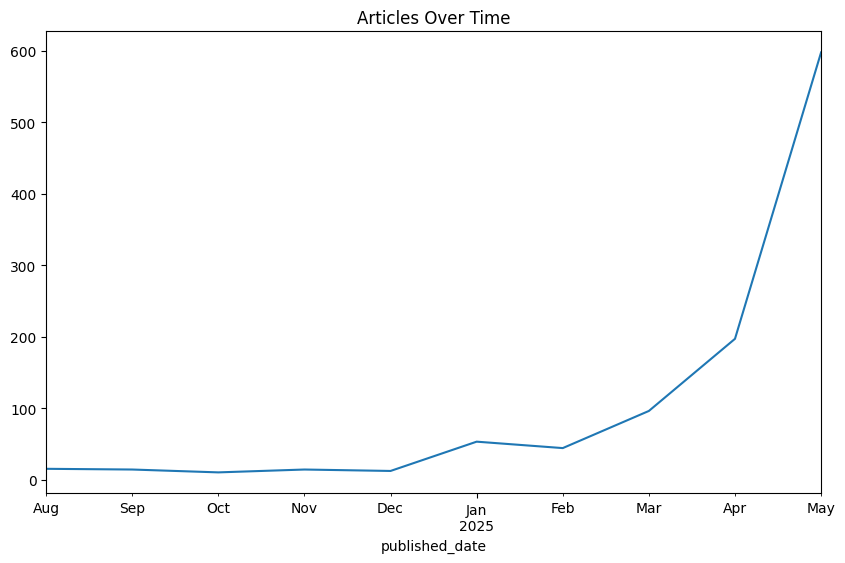

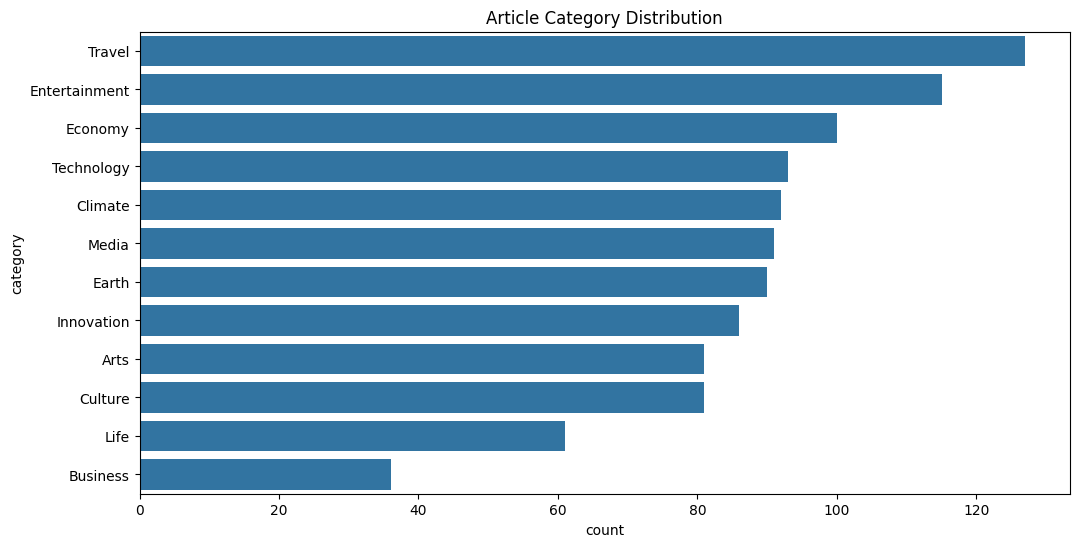

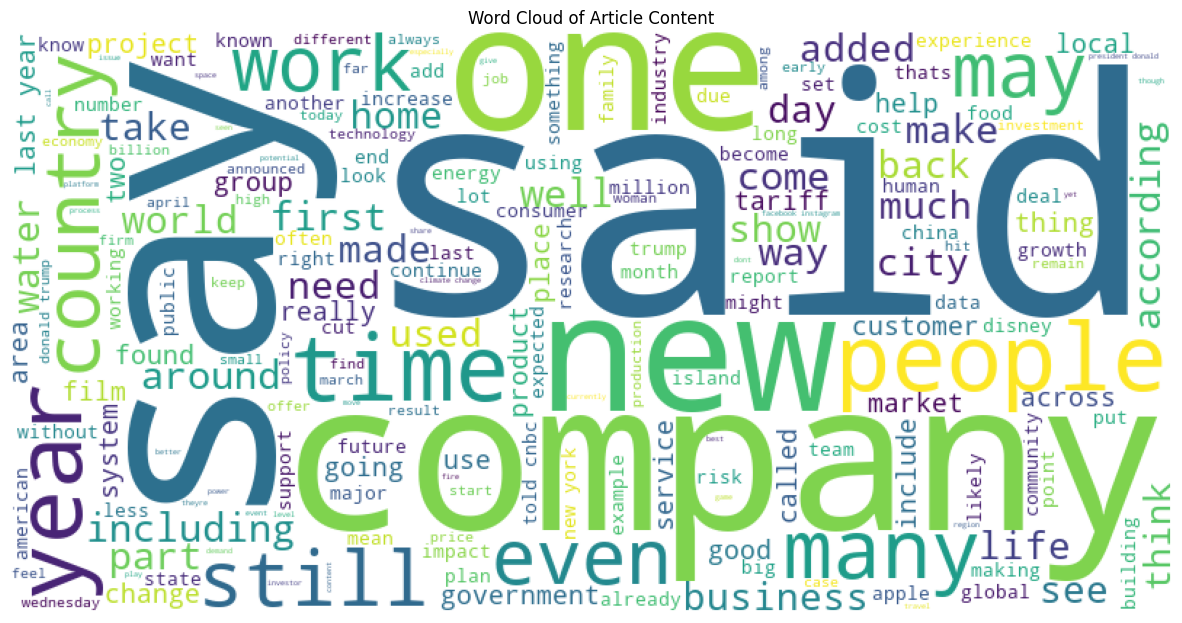

In [17]:
# Basic Statistics
print("\nBasic Statistics:")
print("Average word count:", df['clean_content'].apply(lambda x: len(x.split())).mean())
print("Most common words:", pd.Series(' '.join(df['clean_content']).split()).value_counts()[:10])

# Temporal Analysis (if dates available)
if pd.api.types.is_datetime64_any_dtype(df['published_date']):
    plt.figure(figsize=(10,6))
    df.set_index('published_date').resample('ME').size().plot()
    plt.title('Articles Over Time')
    plt.show()

# Category Analysis
plt.figure(figsize=(12,6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Article Category Distribution')
plt.show()

# Word Cloud
plt.figure(figsize=(15,10))
wordcloud = WordCloud(width=800, height=400,
                     background_color='white').generate(' '.join(df['clean_content']))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Word Cloud of Article Content")
plt.show()

In [20]:
df.to_csv('preprocessed_news_articles.csv', index=False)
print(f"Final preprocessed dataset: {len(df)} articles")

Final preprocessed dataset: 1053 articles


# Part 3: Vectorization

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import numpy as np
from collections import defaultdict

In [21]:
# Load preprocessed data
df = pd.read_csv('preprocessed_news_articles.csv')

# Verify class distribution
print("Current Class Distribution:")
print(df['category'].value_counts())

Current Class Distribution:
category
Travel           127
Entertainment    115
Economy          100
Technology        93
Climate           92
Media             91
Earth             90
Innovation        86
Arts              81
Culture           81
Life              61
Business          36
Name: count, dtype: int64


In [24]:
# Step 1: Enhanced Category Mapping
category_mapping = {
    'Climate': 'Environment',
    'Earth': 'Environment',
    'Economy': 'Business',
    'Innovation': 'Technology',
    'Media': 'Entertainment',
    'Culture': 'Lifestyle',
    'Arts': 'Lifestyle',
    'Life': 'Lifestyle',
    'Travel': 'Lifestyle'
}

# Apply mapping with fallback
df['mapped_category'] = df['category'].map(category_mapping).fillna(df['category'])
df.sample(n=10)

published_date                                           headline  \
693  2025-05-15 23:52:42  Cerebras CEO says chipmaker’s ‘aspiration’ is ...   
904  2025-05-11 11:00:01  Trump’s trade war is giving renewed importance...   
389  2025-05-09 13:20:19    UK tour of Jack Thorne's vampire play cancelled   
977  2024-08-27 19:26:14  Edgar Bronfman Jr. dropped Paramount bid after...   
494  2025-03-26 16:00:00           Kandi Burruss's weekend guide to Atlanta   
635  2025-05-22 11:07:15  Hong Kong passes stablecoin bill as more gover...   
186  2025-05-19 12:54:24  Lineker to leave BBC sooner than planned after...   
782  2025-04-14 18:57:30  5.2-magnitude earthquake strikes Julian, Calif...   
810  2025-02-09 23:02:54  The world isn’t close to breaking free from co...   
255  2025-03-01 10:00:00  Why Vermont farmers are using urine on their c...   

    publisher                                    article_content    category  \
693      cnbc  Cerebras CEO Andrew Feldman said his hope is t...  Technology   
904      cnbc  Media companies are staring down widespread ec...       Media   
389       bbc  The UK tour of Let the Right One In, written b...        Arts   
977      cnbc  Edgar Bronfman Jr. walked away from his bid fo...       Media   
494       bbc  The musician, producer and Real Housewives: At...      Travel   
635      cnbc  Hong Kong passed a stablecoin bill on Wednesda...  Technology   
186       bbc  Gary Lineker has confirmed he will leave the B...     Culture   
782      cnbc  A preliminary 5.2-magnitude earthquake struck ...     Climate   
810      cnbc  The world won't be able to release its grip on...     Climate   
255       bbc  Urine was used as fertiliser in ancient Rome a...       Earth   

                                         clean_content mapped_category  
693  cerebras ceo andrew feldman said hope take com...      Technology  
904  medium company staring widespread economic unc...   Entertainment  
389  tour let right one written cocreator adolescen...       Lifestyle  
977  edgar bronfman walked away bid paramount compa...   Entertainment  
494  musician producer real housewife atlanta break...       Lifestyle  
635  hong kong passed stablecoin bill wednesday exp...      Technology  
186  gary lineker confirmed leave bbc presenting fi...       Lifestyle  
782  preliminary magnitude earthquake struck julian...     Environment  
810  world wont able release grip coal anytime soon...     Environment  
255  urine used fertiliser ancient rome china farme...     Environment

In [25]:
# Step 2: TF-IDF Vectorization with Class-Aware Parameters
tfidf = TfidfVectorizer(
    max_features=8000,               # Increased for 12 classes
    ngram_range=(1, 3),             # Bigrams/trigrams help with multi-class
    stop_words='english',
    min_df=3,                       # Lower min_df to capture class-specific terms
    max_df=0.6,                     # More aggressive common term filtering
    sublinear_tf=True,              # Logarithmic scaling
    analyzer='word',                # Keep as words (not char)
    smooth_idf=True
)

# Fit TF-IDF
tfidf_matrix = tfidf.fit_transform(df['clean_content'])
tfidf_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 250235 stored elements and shape (1053, 8000)>

In [29]:
# Step 3: Label Encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['mapped_category'])
encoded_labels

array([0, 0, 0, ..., 3, 3, 3], shape=(1053,))

In [31]:
# Step 4: Create Dataset with Top Features per Class
# Get top 50 features per class
feature_names = tfidf.get_feature_names_out()
class_feature_importance = defaultdict(list)

for i, class_name in enumerate(label_encoder.classes_):
    class_indices = np.where(encoded_labels == i)[0]
    class_tfidf = tfidf_matrix[class_indices]
    top_features = np.argsort(np.asarray(class_tfidf.mean(axis=0)).ravel())[-50:][::-1]
    class_feature_importance[class_name] = [feature_names[j] for j in top_features]

# Save important features
pd.DataFrame(class_feature_importance).to_csv('class_specific_features.csv', index=False)

class_feature_importance

defaultdict(list,
            {'Business': ['tariff',
              'trump',
              'inflation',
              'rate',
              'trade',
              'economy',
              'market',
              'economist',
              'president',
              'economic',
              'pro',
              'policy',
              'price',
              'bank',
              'federal',
              'cut',
              'consumer',
              'growth',
              'higher',
              'cnbc',
              'donald',
              'president donald',
              'donald trump',
              'president donald trump',
              'fed',
              'government',
              'month',
              'cnbc pro',
              'stock',
              'import',
              'recession',
              'central bank',
              'country',
              'good',
              'china',
              'trading',
              'pro live',
              'april',
              't

In [33]:
# Step 5: Final Dataset Assembly
final_data = pd.DataFrame.sparse.from_spmatrix(
    tfidf_matrix,
    columns=feature_names
)
final_data['category'] = encoded_labels
final_data['original_category'] = df['category']

final_data

abandoned  abc   ability      able  able make  able use  aboriginal  \
0             0    0         0  0.054117          0         0           0   
1             0    0         0         0          0         0           0   
2             0    0  0.105944  0.055435          0         0           0   
3             0    0         0         0          0         0           0   
4             0    0  0.050424         0          0         0           0   
...         ...  ...       ...       ...        ...       ...         ...   
1048          0    0         0         0          0         0           0   
1049          0    0         0         0          0         0           0   
1050          0    0         0         0          0         0           0   
1051          0    0         0  0.054293          0         0           0   
1052          0    0         0         0          0         0           0   

      abroad  absence  absolute  ...  youve got  yuan  zaslav  zaslav said  \
0          0        0         0  ...          0     0       0            0   
1          0        0         0  ...          0     0       0            0   
2          0        0         0  ...          0     0       0            0   
3          0        0         0  ...          0     0       0            0   
4          0        0         0  ...          0     0       0            0   
...      ...      ...       ...  ...        ...   ...     ...          ...   
1048       0        0         0  ...          0     0       0            0   
1049       0        0         0  ...          0     0       0            0   
1050       0        0         0  ...          0     0       0            0   
1051       0        0         0  ...          0     0       0            0   
1052       0        0         0  ...          0     0       0            0   

       zealand  zero  zone  zoo  zuckerberg  original_category  
0            0     0     0    0           0           Business  
1            0     0     0    0           0           Business  
2     0.060946     0     0    0           0           Business  
3            0     0     0    0           0           Business  
4            0     0     0    0           0           Business  
...        ...   ...   ...  ...         ...                ...  
1048         0     0     0    0           0               Life  
1049         0     0     0    0           0               Life  
1050         0     0     0    0           0               Life  
1051         0     0     0    0           0               Life  
1052         0     0     0    0           0               Life  

[1053 rows x 8001 columns]

In [34]:
# Save datasets
final_data.to_csv('vectorized_news_12class.csv', index=False)
pd.DataFrame({
    'original_category': df['category'],
    'mapped_category': df['mapped_category'],
    'encoded_label': encoded_labels
}).drop_duplicates().to_csv('category_mapping_12class.csv', index=False)

print("\nVectorization Complete!")
print(f"Final feature matrix shape: {tfidf_matrix.shape}")
print("Class distribution in final data:")
print(pd.Series(encoded_labels).value_counts())


Vectorization Complete!
Final feature matrix shape: (1053, 8000)
Class distribution in final data:
3    350
1    206
2    182
4    179
0    136
Name: count, dtype: int64


# Part 4: Model Building

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [37]:
# Load vectorized data
df = pd.read_csv('vectorized_news_12class.csv')

# Separate features and labels
X = df.drop(columns=['category', 'original_category'])
y = df['category']

# Split dataset (stratified split preserves class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print("Class distribution in test set:")
print(y_test.value_counts())

Training samples: 842
Testing samples: 211
Class distribution in test set:
category
3    70
1    41
2    37
4    36
0    27
Name: count, dtype: int64


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(
        solver='saga',
        max_iter=1000,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42
    ),
    "Linear SVM": LinearSVC(
        class_weight='balanced',
        max_iter=5000,
        random_state=42
    )
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\n{'='*40}\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Store results
    results[name] = {
        'model': model,
        'report': classification_report(y_test, y_pred, output_dict=True),
        'cm': confusion_matrix(y_test, y_pred)
    }
    
    # Print metrics
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))


Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        27
           1       0.88      0.51      0.65        41
           2       1.00      0.81      0.90        37
           3       0.71      0.96      0.82        70
           4       0.77      0.83      0.80        36

    accuracy                           0.81       211
   macro avg       0.85      0.79      0.80       211
weighted avg       0.83      0.81      0.80       211


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        27
           1       0.92      0.54      0.68        41
           2       1.00      0.86      0.93        37
           3       0.72      0.91      0.81        70
           4       0.79      0.83      0.81        36

    accuracy                           0.81

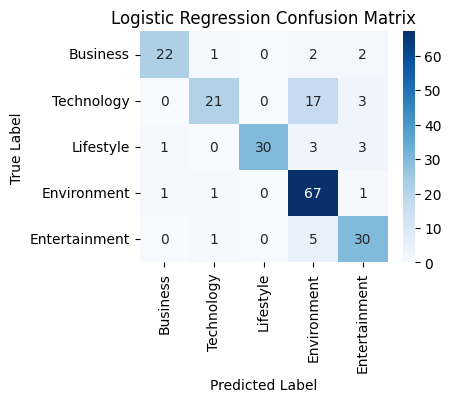

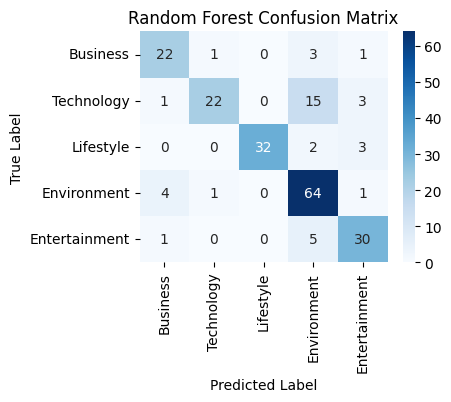

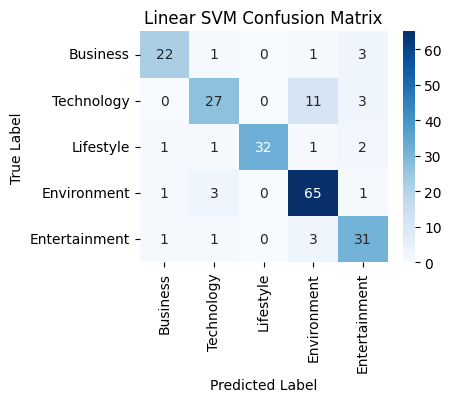


Model Comparison:
                 Model  Macro F1  Weighted F1  Class Variance
0  Logistic Regression  0.804299     0.800549        0.085941
1        Random Forest  0.804060     0.801962        0.079339
2           Linear SVM  0.836027     0.837522        0.064506


In [46]:
# Load label mapping
label_mapping = pd.read_csv('category_mapping_12class.csv')
label_encoder = LabelEncoder()
label_encoder.classes_ = label_mapping['mapped_category'].unique()

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, model_name):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Compare model performance
metrics = []
for model_name, result in results.items():
    report = result['report']
    metrics.append({
        'Model': model_name,
        'Macro F1': report['macro avg']['f1-score'],
        'Weighted F1': report['weighted avg']['f1-score'],
        'Class Variance': np.std([report[str(i)]['f1-score'] for i in range(5)])
    })
    
    # Plot confusion matrix
    plot_confusion_matrix(result['cm'], label_encoder.classes_, model_name)

# Create performance comparison
metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
print(metrics_df[['Model', 'Macro F1', 'Weighted F1', 'Class Variance']])